# Triple Barrier Labeling
1. Load the price data
2. Volatility calculation and event extraction
3. Fixed time horizon labeling
4. Triple barrier labeling
5. Confirmation labeling
6. Plotting and visualization

In [1]:
import pandas as pd
from tqdm.notebook import tqdm  # Use notebook version of tqdm for better compatibility with Jupyter
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.patches as patches
from pandas.tseries.offsets import DateOffset
import plotly.graph_objects as go
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
plt.style.use('default')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load the price data

In [4]:
# db_path = '../raw/daily-2020.csv'
db_path = '/content/drive/MyDrive/daily-2020.csv'
price_df = pd.read_csv(db_path, usecols=["timestamp", "close", "open", "high", "low", "volume"])
price_df.set_index('timestamp', inplace=True)
price_df.index = pd.to_datetime(price_df.index, unit='s')

### Volatility calculation and event extraction

In [5]:
def get_daily_vol(close, span0=100):
    """
    Calculate the daily volatility of closing prices.

    Parameters:
    - close: A pandas Series of closing prices.
    - span0: The span for the EWM standard deviation.

    Returns:
    - A pandas Series of daily volatility estimates.
    """
    # Find the start of the previous day for each day
    prev_day_start = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    prev_day_start = prev_day_start[prev_day_start > 0]

    # Create a series with the start of the previous day for each day
    prev_day_start = pd.Series(close.index[prev_day_start - 1], index=close.index[close.shape[0] - prev_day_start.shape[0]:])

    # Calculate daily returns
    daily_returns = close.loc[prev_day_start.index] / close.loc[prev_day_start.values].values - 1

    # Calculate EWM standard deviation of daily returns
    daily_vol = daily_returns.ewm(span=span0).std()

    return daily_returns, daily_vol

In [6]:
price_df["daily_returns"], price_df["volatility"] = get_daily_vol(price_df.close)

In [7]:
price_df.dropna(inplace=True)

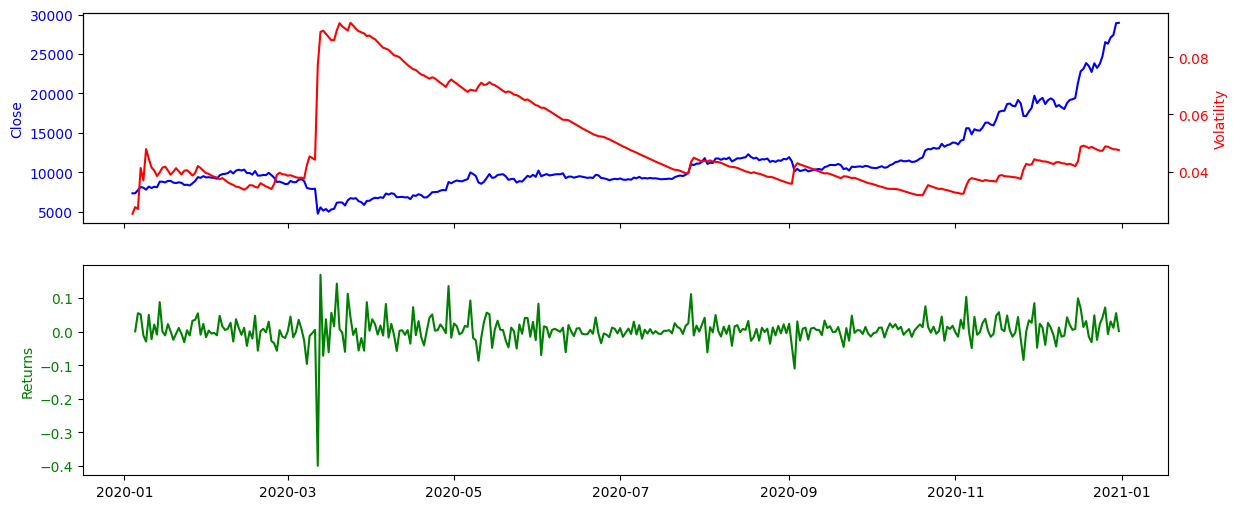

In [8]:
# Calculate returns
price_df['returns'] = price_df['close'].pct_change()

# Create a new figure with two subplots
fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True, figsize=(14, 6))

# Plot 'close' on the primary y-axis of the first subplot
ax1.plot(price_df.index, price_df['close'], color='blue')
ax1.set_ylabel('Close', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for 'volatility' on the first subplot
ax2 = ax1.twinx()
ax2.plot(price_df.index, price_df['volatility'], color='red')
ax2.set_ylabel('Volatility', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Plot 'returns' on the second subplot
ax3.plot(price_df.index, price_df['returns'], color='green')
ax3.set_ylabel('Returns', color='green')
ax3.tick_params(axis='y', labelcolor='green')

# Show the plot
plt.show()

In [9]:
def get_t_events(raw_price, volatility, base_threshold):
    """
    :param raw_price: (series) of close prices.
    :param volatility: (series) of volatility values.
    :param base_threshold: (float) base level for the threshold.
    :return: (datetime index vector) vector of datetimes when the events occurred. This is used later to sample.
    """
    print('Applying Symmetric CUSUM filter.')

    t_events, s_pos, s_neg = [], 0, 0

    # log returns
    diff = np.log(raw_price).diff().dropna()

    # Get event time stamps for the entire series
    for i in tqdm(diff.index[1:]):
        # Adjust the threshold based on volatility
        threshold = base_threshold * volatility.loc[i]

        s_pos = max(0.0, float(s_pos + diff.loc[i]))
        s_neg = min(0.0, float(s_neg + diff.loc[i]))

        if s_neg < -threshold:
            s_neg = 0
            t_events.append(i)

        elif s_pos > threshold:
            s_pos = 0
            t_events.append(i)

    event_timestamps = pd.DatetimeIndex(t_events)
    return event_timestamps

In [10]:
events = get_t_events(price_df.close, price_df.volatility, 1.5)

Applying Symmetric CUSUM filter.


  0%|          | 0/361 [00:00<?, ?it/s]

In [11]:
price_df["event"] = price_df.index.isin(events)

In [12]:
price_df

,open,high,low,close,volume,daily_returns,volatility,returns,event
timestamp,,,,,,,,,
2020-01-04,7341.60,7400.00,7269.21,7350.71,92586.033,0.055827,0.025314,NaN,False
2020-01-05,7350.54,7495.00,7303.00,7354.36,117765.972,0.001722,0.027620,0.000497,False
2020-01-06,7354.36,7808.65,7345.00,7757.39,168150.317,0.055325,0.026958,0.054802,True
2020-01-07,7757.74,8215.33,7733.00,8152.49,280809.162,0.108525,0.041275,0.050932,False
2020-01-08,8150.90,8468.42,7870.11,8059.84,321225.114,0.038989,0.036967,-0.011365,False
...,...,...,...,...,...,...,...,...,...
2020-12-27,26508.84,28459.84,25850.00,26305.64,540264.148,0.063714,0.048716,-0.007665,False
2020-12-28,26301.76,27538.82,26117.10,27102.66,267563.468,0.022401,0.048231,0.030298,True
2020-12-29,27101.45,27441.73,25913.01,27402.83,260759.449,0.041709,0.047837,0.011075,False


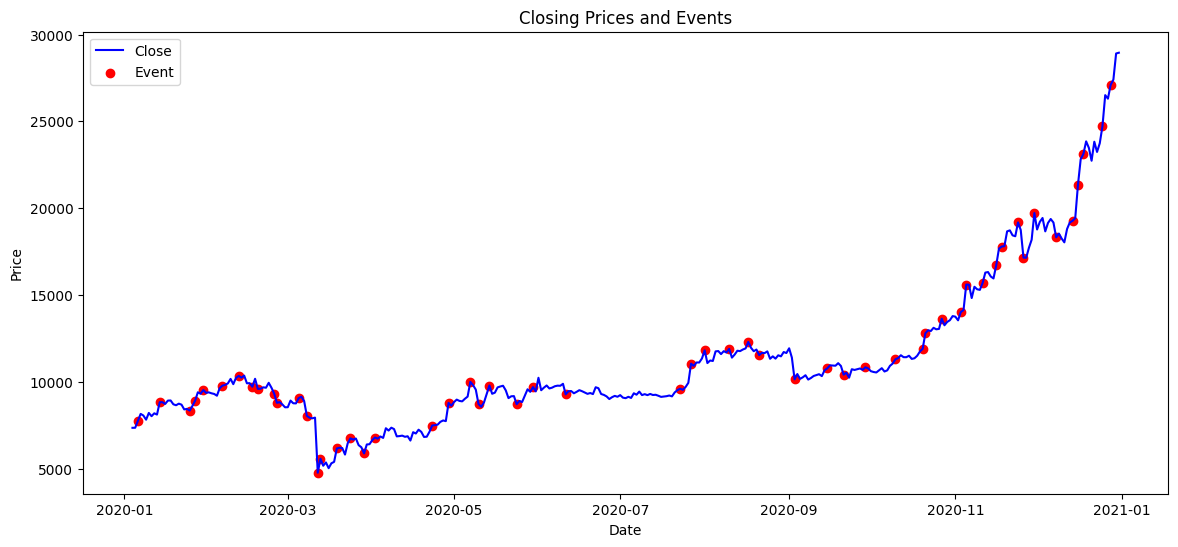

In [13]:
# Plot the closing prices
plt.subplots(figsize=(14, 6))
plt.plot(price_df.index, price_df['close'], color='blue', label='Close')

# Add dots for the event dates
plt.scatter(events, price_df.loc[events, 'close'], color='red', label='Event')

# Set the labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Closing Prices and Events')
plt.legend()

# Show the plot
plt.show()

### Fixed time horizon labeling

In [14]:
def fixed_time_horizon_labeling(price_series, h):
    """
    Perform fixed time horizon labeling on a price series.

    Parameters:
    - price_series: A pandas Series of prices.
    - h: The bar horizon.

    Returns:
    - A pandas Series of labels (-1, 0, 1).
    """
    # Split the price series into non-overlapping windows of size h
    windows = [price_series[i:i+h] for i in range(0, len(price_series), h)]

    # Initialize an empty list to store the labels
    labels = []

    # For each window, compare the last item with the first item and assign a label accordingly
    for window in windows:
        # print("last candle in window: ", window.iloc[-1], "first candle in window: ", window.iloc[0], window.iloc[-1] > window.iloc[0])
        if len(window) == h:  # Ensure the window is of size h
            if window.iloc[-1] > window.iloc[0]:
                labels.extend([1]*h)  # Bullish
            elif window.iloc[-1] < window.iloc[0]:
                labels.extend([-1]*h)  # Bearish
            else:
                labels.extend([0]*h)  # Neutral

    # Convert the list of labels into a pandas Series
    labels = pd.Series(labels, index=price_series.index[:len(labels)])

    return labels

In [15]:
def band_generator(labels):
    bands = [{'label': labels.iloc[0], 'from': labels.index[0]}]
    for l, i in enumerate(labels):
        if i == bands[-1]["label"]:
            pass
        else:
            bands[-1]["to"] = labels.index[l]
            # Check if l + 1 is within the range of the labels' indices
            if l + 1 < len(labels):
                bands.append({'label': i, 'from': labels.index[l + 1]})

    # Check if the last band has a 'to' field
    if 'to' not in bands[-1]:
        bands[-1]['to'] = labels.index[-1]

    return bands

In [16]:
def plot_labels(price_series, labels):
    """
    Plot price series with bullish and bearish areas.

    Parameters:
    - price_series: A pandas Series of prices.
    - labels: A pandas Series of labels (-1, 0, 1).
    """
    # Create a new figure
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax2 = ax1.twinx()

    # Plot the price series
    ax1.plot(price_series.index, price_series.values, label='Price', color='blue')

    # Draw a box for each window
    for label in labels:
        # Shift "from" and "to" by half a day
        from_timestamp = label["from"] - DateOffset(hours=12)
        to_timestamp = label["to"] + DateOffset(hours=12)

        # Ensure the timestamps are within the price series index
        from_timestamp = max(from_timestamp, price_series.index[0])
        to_timestamp = min(to_timestamp, price_series.index[-1])

        # Add the band
        ax2.fill_betweenx(ax1.get_ylim(), from_timestamp, to_timestamp, color='green' if label["label"] == 1 else "red" if label["label"] == -1 else 'white' , alpha=0.3)

    # Add a legend
    ax1.legend()

    # Show the plot
    plt.show()

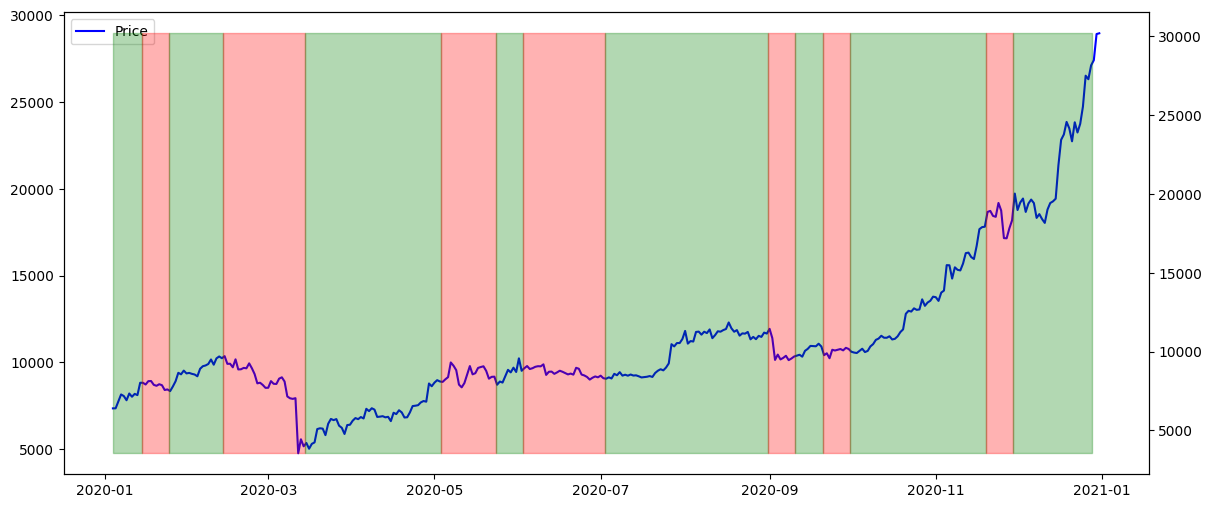

In [17]:
labels = fixed_time_horizon_labeling(price_df.close, 10)
bands = band_generator(labels)
plot_labels(price_df.close, bands)

In [18]:
labels.value_counts()

 1    240
-1    120
Name: count, dtype: int64

In [19]:
price_df["labels"] = labels

### Triple barrier labeling

In [20]:
# Define labels as named constants for readability
LABEL_UP = 1
LABEL_DOWN = -1
LABEL_NEUTRAL = 0

In [21]:
def calculate_barriers(df, i, window, upper_barrier_factor, lower_barrier_factor, volatility_period, barrier_type='volatility'):
    end_window = min(i+window, len(df)-1)  # Ensure the window does not exceed the dataframe

    # Calculate the mean volatility or daily returns over the volatility_period
    if barrier_type == 'volatility':
        mean_value = df.loc[i-volatility_period+1:i, 'volatility'].mean()
        current_value = df.loc[i, 'volatility']
    elif barrier_type == 'returns':
        mean_value = df.loc[i-volatility_period+1:i, 'daily_returns'].mean()
        current_value = df.loc[i, 'daily_returns']
    else:
        print(f'the barrier type: {barrier_type}')
        raise ValueError("Invalid barrier_type. Choose either 'volatility' or 'returns'")

    df.loc[i:end_window, 'upper_barrier'] = df.loc[i, 'close'] + (df.loc[i, 'close'] * current_value * upper_barrier_factor)
    df.loc[i:end_window, 'lower_barrier'] = df.loc[i, 'close'] - (df.loc[i, 'close'] * current_value * lower_barrier_factor)
    return df

In [22]:
def label_observations(df, origin, i, label):
    df.loc[origin:i+1, 'labels'] = label
    return df

In [23]:
def triple_barrier_labeling(sdf, volatility_period=7, upper_barrier_factor=1, lower_barrier_factor=1, vertical_barrier=7, min_trend_days=2, barrier_type='volatility', touch_type="HL"):
    df = sdf.copy()
    df = df.reset_index()

    # Initialize labels and window start
    df['labels'] = LABEL_NEUTRAL
    df['window_start'] = False

    window = vertical_barrier
    origin = 0
    touch_upper = lambda high, barrier: high >= barrier
    touch_lower = lambda low, barrier: low <= barrier
    # For each observation
    for i in range(0, len(df)):
        # Define your barriers at the beginning of each window
        if i == origin:
            df = calculate_barriers(df, i, window, upper_barrier_factor, lower_barrier_factor, volatility_period, barrier_type)
            df.loc[i, 'window_start'] = True  # Mark the start of the window

        # one of the conditions were met
        if touch_upper(df.loc[i, "high" if touch_type == 'HL' else 'close'], df.loc[i, "upper_barrier"]):
            if (i - origin > min_trend_days):
                # label the observations
                df = label_observations(df, origin, i, LABEL_UP)
                # set new origin
                origin = i + 1 if i + 1 < len(df) else i  # Check if i + 1 is within the DataFrame's index
                # reset window
                window = vertical_barrier
        elif touch_lower(df.loc[i, "low" if touch_type == 'HL' else 'close'], df.loc[i, "lower_barrier"]):
            if (i - origin > min_trend_days):
                # label the observations
                df = label_observations(df, origin, i, LABEL_DOWN)
                # set new origin
                origin = i + 1 if i + 1 < len(df) else i  # Check if i + 1 is within the DataFrame's index
                # reset window
                window = vertical_barrier

        # none of the conditions were met
        else:
            if window > 0:
                # reduce window size by one
                window = window - 1
            else:
                # reset window
                window = vertical_barrier
                # label neutral from origin to origin + window
                df.loc[origin:min(origin+window, len(df)-1), 'labels'] = LABEL_NEUTRAL  # Ensure the window does not exceed the dataframe
                # set origin to the next id
                origin = i + 1 if i + 1 < len(df) else i  # Check if i + 1 is within the DataFrame's index

    df = df.set_index("timestamp")
    return df

In [24]:
tbl_df = triple_barrier_labeling(price_df, volatility_period=10, upper_barrier_factor=1.5, lower_barrier_factor=1.2, vertical_barrier=7, min_trend_days=2, barrier_type='volatility')

In [25]:
tbl_df.labels.value_counts()

labels
 1    152
 0    146
-1     65
Name: count, dtype: int64

In [26]:
def plot_triple_barrier(df,loc=1,sample_point_index=10, start_index = 0, n_days = 100 ,time_out = 20 ):
  """
    parameters :
      loc = 1 => position of smaller plot up
      loc = 2 => position of smaller plot down
      sample_point_index : the point which is going to show the labelling details
      time_out : how many next day's data are used for labeling of each point
  """
  price = df.close.to_numpy()[start_index:start_index+n_days]
  # Set initial barriers
  profit_taking = 1.0  # Multiplier for the volatility adjustment
  stop_loss = 1.0  # Multiplier for the volatility adjustment

  # Calculate rolling volatility (standard deviation)
  window = 10  # Window size for rolling calculation
  rolling_volatility = pd.Series(price).rolling(window=window).std().fillna(0)

  # Initialize arrays to hold the barrier values
  upper_barrier = np.zeros(n_days)
  lower_barrier = np.zeros(n_days)

  # Initialize arrays to hold labels
  high_points = np.zeros(n_days, dtype=bool)
  low_points = np.zeros(n_days, dtype=bool)
  neutral_points = np.zeros(n_days, dtype=bool)

  # Iterate over each day to calculate barriers and labels
  for i in range(n_days):
      if i + time_out < n_days:
          future_prices = price[i:i + time_out]
          upper_barrier[i] = price[i] + (profit_taking * rolling_volatility[i])
          lower_barrier[i] = price[i] - (stop_loss * rolling_volatility[i])

          # Check if any future price crosses the barriers
          if np.any(future_prices >= upper_barrier[i]):
              high_points[i] = True
          elif np.any(future_prices <= lower_barrier[i]):
              low_points[i] = True
          else:
              neutral_points[i] = True
      else:
          upper_barrier[i] = np.nan
          lower_barrier[i] = np.nan
          neutral_points[i] = True

  # Plot the stock prices and barriers
  fig, ax = plt.subplots(figsize=(14, 7))
  ax.plot(price, label='Stock Price', color='blue')
  ax.plot(upper_barrier, color='green', linestyle='--', label='Profit Taking Barrier (Volatility Adjusted)')
  ax.plot(lower_barrier, color='red', linestyle='--', label='Stop Loss Barrier (Volatility Adjusted)')
  ax.axvline(time_out, color='purple', linestyle='--', label='Time Out Barrier')

  # Highlight high, low, and neutral points
  ax.scatter(np.where(high_points)[0], price[high_points], color='green', marker='^', label='High Points')
  ax.scatter(np.where(low_points)[0], price[low_points], color='red', marker='v', label='Low Points')
  ax.scatter(np.where(neutral_points)[0], price[neutral_points], color='orange', marker='o', label='Neutral Points')

  # Adding labels and title
  ax.set_xlabel('Days')
  ax.set_ylabel('Price')
  ax.set_title('Stock Prices with Volatility-Adjusted Triple Barrier and Points Classification')
  ax.legend()
  ax.grid(True)



  if sample_point_index is not np.nan:
      if loc == 1:
        inset_ax = inset_axes(ax, width="25%", height="25%", loc=9)
      else:
        inset_ax = inset_axes(ax, width="25%", height="25%", loc=8)

      inset_ax.plot(range(sample_point_index, sample_point_index + time_out), price[sample_point_index:sample_point_index + time_out], label='Stock Price', color='blue')
      inset_ax.plot(range(sample_point_index, sample_point_index + time_out), np.full(time_out, upper_barrier[sample_point_index]), color='green', linestyle='--', label='Upper Barrier')
      inset_ax.plot(range(sample_point_index, sample_point_index + time_out), np.full(time_out, lower_barrier[sample_point_index]), color='red', linestyle='--', label='Lower Barrier')
      inset_ax.grid(True)

      if loc == 1 :
        pos = (0.5, 0.9)
      else :
        pos = (0.3, 0.3)

      ax.annotate('',
                  xy=(sample_point_index, price[sample_point_index]),
                  xycoords='data',
                  xytext=pos,
                  textcoords='axes fraction',
                  arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5),
                  horizontalalignment='right', verticalalignment='bottom')

  plt.show()

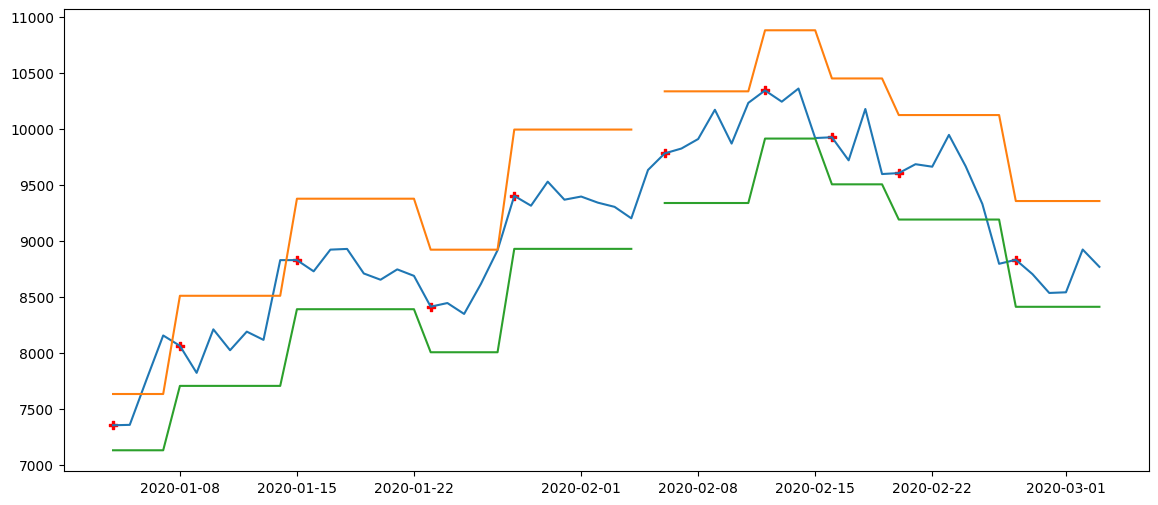

In [27]:
plot_df = tbl_df[0:60]
# Create a new DataFrame where 'window_start' is True
window_starts = plot_df[plot_df['window_start']]

plt.subplots(figsize=(14, 6))

# Plot the 'close', 'upper_barrier', and 'lower_barrier' columns
plt.plot(plot_df.index, plot_df[['close', 'upper_barrier', 'lower_barrier']], ms=1)

# Add markers at the start of each window
plt.scatter(window_starts.index, window_starts['close'], color='red', marker="P")

plt.show()

In [28]:
tbl_df.shape

(363, 13)

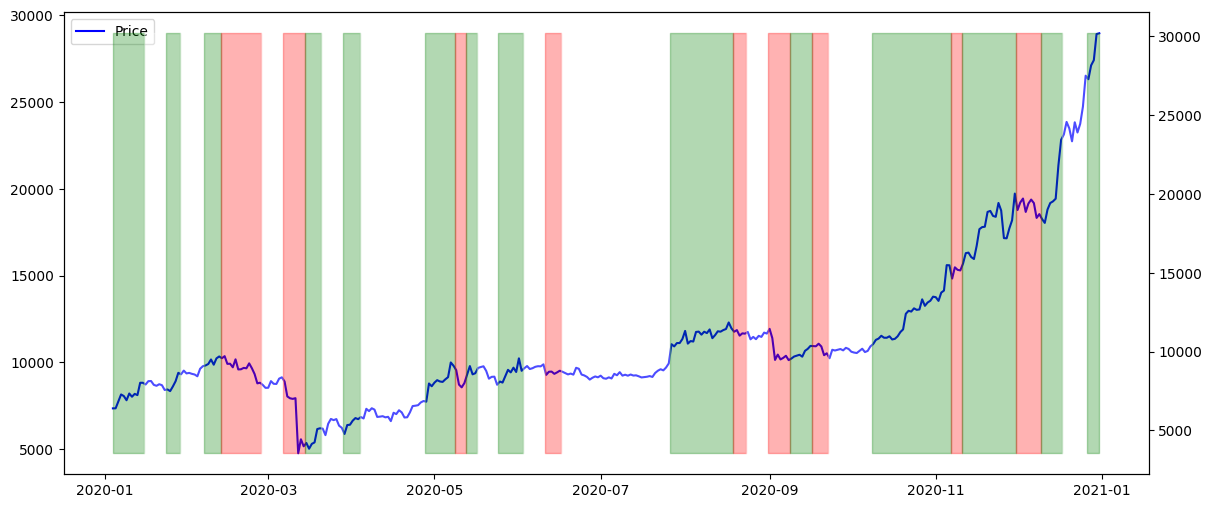

In [29]:
prices = tbl_df
bands = band_generator(prices.labels)
plot_labels(prices.close, bands)

### Confirmations labeling

In [30]:
def market_confirmed_labels(sdf, volatility_period=7, upper_barrier_factor=1, lower_barrier_factor=1, vertical_barrier=7):
    """
    Calculate market confirmed labels.

    Parameters:
    - df: A pandas DataFrame with 'close', 'volatility', 'high', and 'low' columns.
    - volatility_period: The number of periods used to calculate volatility.
    - upper_barrier_factor: The factor used to calculate the upper barrier.
    - lower_barrier_factor: The factor used to calculate the lower barrier.
    - vertical_barrier: The size of the window.
    """
    df = sdf.reset_index()
    # Initialize labels and window start
    df['up_confirmed'] = False
    df['down_confirmed'] = False
    df['neutral_confirmed'] = False
    df['window_start'] = False

    # Calculate barriers and labels for each window
    for i in range(volatility_period, len(df)):
        # Calculate the mean volatility over the volatility_period
        mean_volatility = df.loc[i-volatility_period+1:i, 'volatility'].mean()

        # Calculate the barriers
        upper_barrier = df.loc[i, 'close'] + (df.loc[i, 'close'] * mean_volatility * upper_barrier_factor)
        lower_barrier = df.loc[i, 'close'] - (df.loc[i, 'close'] * mean_volatility * lower_barrier_factor)

        # Determine the window
        end_window = min(i+vertical_barrier, len(df)-1)  # Adjust the window size if it exceeds the DataFrame
        window = df.loc[i+1:end_window]

        # Check if the barriers are touched within the window
        df.loc[i, 'up_confirmed'] = window['high'].max() >= upper_barrier
        df.loc[i, 'down_confirmed'] = window['low'].min() <= lower_barrier
        df.loc[i, 'neutral_confirmed'] = not df.loc[i, 'up_confirmed'] and not df.loc[i, 'down_confirmed']

        # Mark the start of the window
        df.loc[i, 'window_start'] = True

    df.set_index('timestamp', inplace=True)
    return df

In [31]:
def plot_confirmed_labels(df):
    """
    Plot price series with confirmation bands.

    Parameters:
    - df: A pandas DataFrame with 'close', 'up_confirmed', 'down_confirmed', and 'neutral_confirmed' columns.
    """
    # Create a new figure
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax2 = ax1.twinx()

    # Plot the price series
    ax1.plot(df.index, df['close'], label='Price', color='blue')

    # Draw a box for each window
    for i in range(len(df)):
        if df.iloc[i]['window_start']:
            # Shift "from" and "to" by half a day
            from_timestamp = df.index[i] - DateOffset(hours=12)
            to_timestamp = df.index[i+1] if i+1 < len(df) else df.index[-1]

            # Ensure the timestamps are within the price series index
            from_timestamp = max(from_timestamp, df.index[0])
            to_timestamp = min(to_timestamp, df.index[-1])

            # Determine the color of the band
            if df.iloc[i]['up_confirmed'] and df.iloc[i]['down_confirmed'] and df.iloc[i]['neutral_confirmed']:
                color = 'yellow'  # Combination of green, red, and white
                label = 'Up & Down & Neutral Confirmed'
            elif df.iloc[i]['up_confirmed'] and df.iloc[i]['down_confirmed']:
                color = 'orange'  # Combination of green and red
                label = 'Up & Down Confirmed'
            elif df.iloc[i]['up_confirmed'] and df.iloc[i]['neutral_confirmed']:
                color = 'lightgreen'  # Combination of green and white
                label = 'Up & Neutral Confirmed'
            elif df.iloc[i]['down_confirmed'] and df.iloc[i]['neutral_confirmed']:
                color = 'pink'  # Combination of red and white
                label = 'Down & Neutral Confirmed'
            elif df.iloc[i]['up_confirmed']:
                color = 'green'
                label = 'Up Confirmed'
            elif df.iloc[i]['down_confirmed']:
                color = 'red'
                label = 'Down Confirmed'
            else:  # df.iloc[i]['neutral_confirmed'] is True
                color = 'white'
                label = 'Neutral Confirmed'

            # Add the band
            ax2.fill_betweenx(ax1.get_ylim(), from_timestamp, to_timestamp, color=color, alpha=0.3)

    # Add a legend
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    # Create custom patches for the legend
    patch1 = mpatches.Patch(color='yellow', label='UP & DOWN & Neutral')
    patch2 = mpatches.Patch(color='orange', label='UP & DOWN')
    patch3 = mpatches.Patch(color='lightgreen', label='UP & Neutral')
    patch4 = mpatches.Patch(color='pink', label='DOWN & Neutral')
    patch5 = mpatches.Patch(color='green', label='UP')
    patch6 = mpatches.Patch(color='red', label='DOWN')
    patch7 = mpatches.Patch(color='white', label='Neutral')

    ax2.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7], loc='upper left', prop={'size': 6})
    # Show the plot
    plt.show()

In [32]:
conf_df = market_confirmed_labels(price_df)

In [33]:
conf_df.neutral_confirmed.value_counts()

neutral_confirmed
False    306
True      57
Name: count, dtype: int64

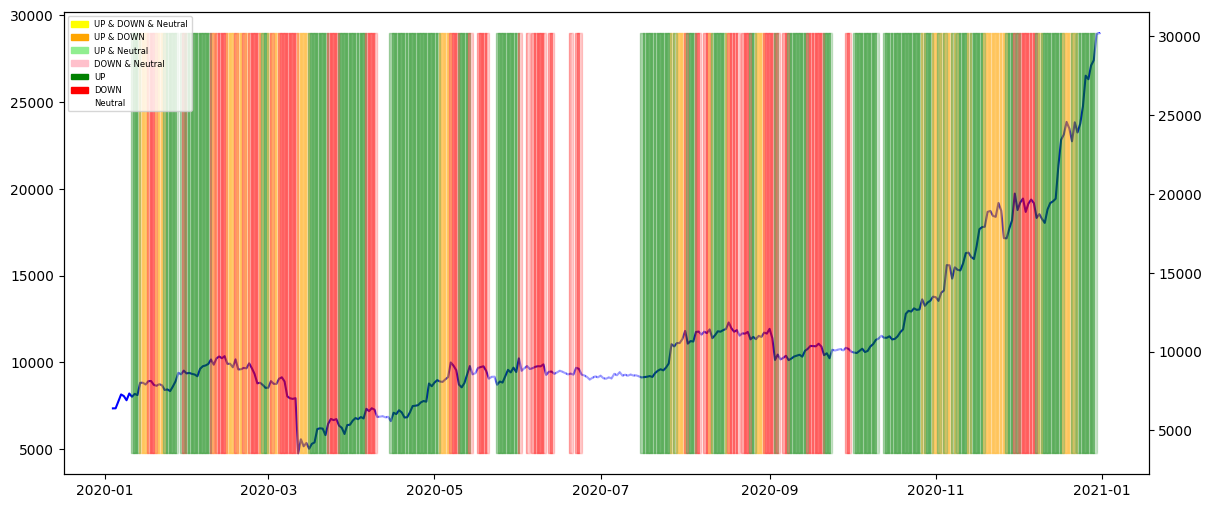

In [34]:
plot_confirmed_labels(conf_df)

### Next day labeling

In [35]:
next_vola_df = triple_barrier_labeling(price_df, volatility_period=7, upper_barrier_factor=0.5, lower_barrier_factor=0.5, vertical_barrier=1, min_trend_days=0, touch_type='close')

In [36]:
next_vola_df.labels.value_counts()

labels
 0    240
 1     75
-1     48
Name: count, dtype: int64

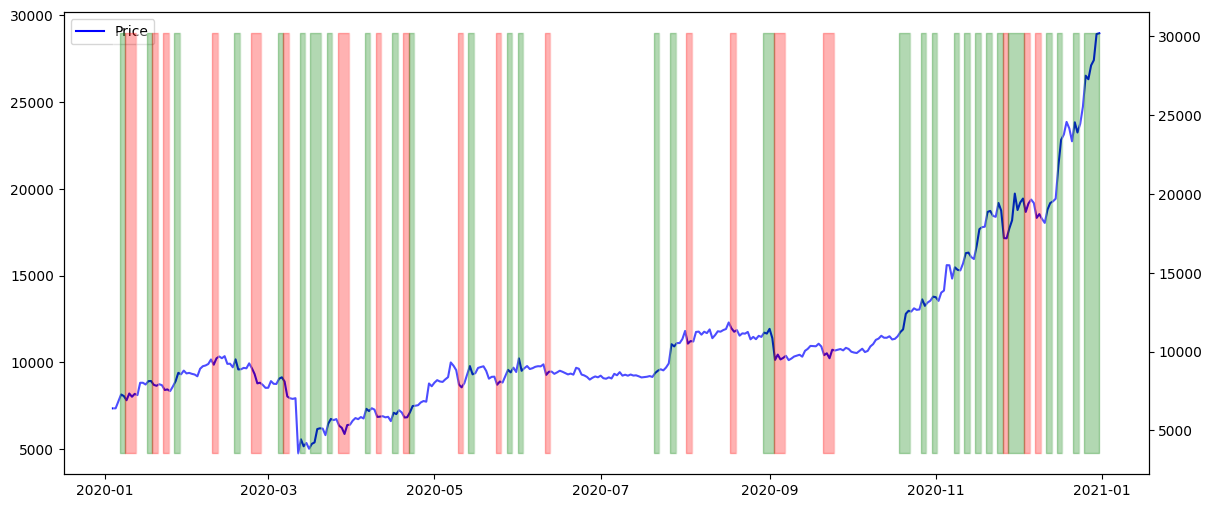

In [37]:
prices = next_vola_df
bands = band_generator(prices.labels)
plot_labels(prices.close, bands)

In [38]:
next_ret_df = triple_barrier_labeling(price_df, volatility_period=7, upper_barrier_factor=1, lower_barrier_factor=1, vertical_barrier=2, min_trend_days=0, barrier_type='returns', touch_type='close')

In [39]:
next_ret_df.labels.value_counts()

labels
 1    168
 0    132
-1     63
Name: count, dtype: int64

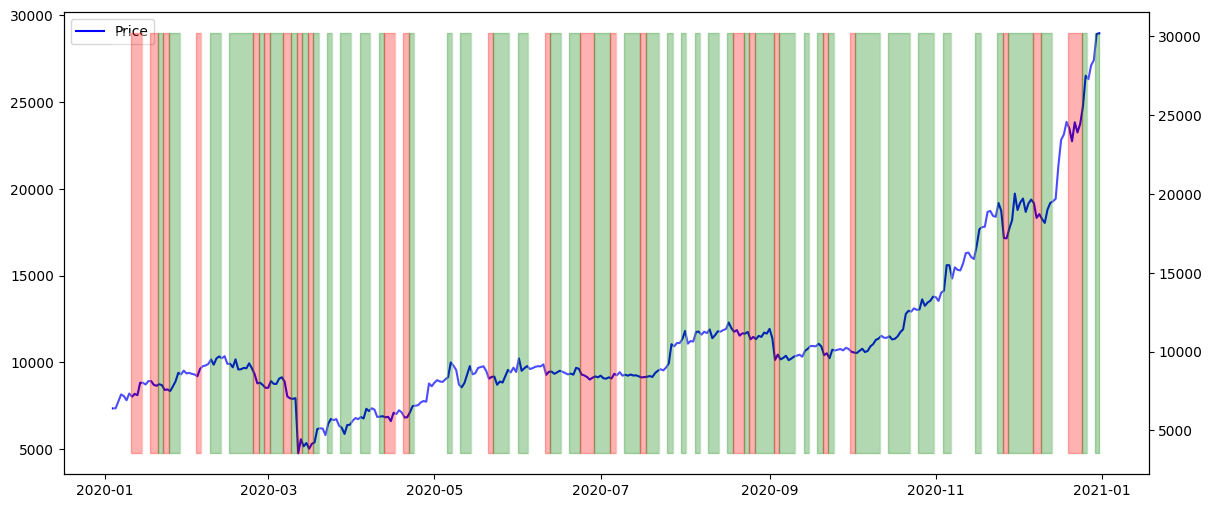

In [40]:
prices = next_ret_df
bands = band_generator(prices.labels)
plot_labels(prices.close, bands)

### Plotting and Visualization

In [41]:
def plot_first_window(df, volatility_period=7, points_before=10, points_after=10):
    """
    Plot the first window in the dataset.

    Parameters:
    - df: A pandas DataFrame with 'open', 'high', 'low', 'close', 'upper_barrier', and 'lower_barrier' columns.
    - volatility_period: The number of periods used to calculate volatility.
    - points_before: The number of points before the window to display.
    - points_after: The number of points after the window to display.
    """
    # Find the first window
    first_window_start = df[df['window_start']].index[2]
    first_window_end = df[df['window_start']].index[3] if len(df[df['window_start']]) > 1 else df.index[-1]

    # Calculate the start and end of the plot
    plot_start = max(first_window_start - pd.Timedelta(points_before, unit='D'), df.index[0])
    plot_end = min(first_window_end + pd.Timedelta(points_after, unit='D'), df.index[-1])

    # Extract the data to plot
    plot_data = df.loc[plot_start:plot_end]

    # Create a new Series for window starts
    scatter_series = plot_data['close'].where(plot_data['window_start'])

    # Create additional plots for the upper and lower barriers
    addplot = [mpf.make_addplot(plot_data['upper_barrier'], color='green'),
               mpf.make_addplot(plot_data['lower_barrier'], color='red'),
               mpf.make_addplot(plot_data['volatility'].rolling(2).mean(), color='yellow'),
               mpf.make_addplot(scatter_series, color='red', type='scatter', label="added scatter")]

    # Create a new figure
    fig, axes = mpf.plot(plot_data, type='candle', style='yahoo', addplot=addplot, returnfig=True, figratio=(25,10))
    # Get the axis
    ax = axes[0]
    ax2 = axes[1]

    # ax2.fill_betweenx(ax.get_ylim(), first_window_start, first_window_end, color='green', alpha=0.3)

    # Set x-axis to show every two days
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Add an annotation at the end of the first window
    ax.annotate('Window End', xy=(first_window_end, df.loc[first_window_end, 'close']), xytext=(-15, 15),
                textcoords='offset points', arrowprops=dict(arrowstyle='->'))

    # Remove grid lines
    ax.grid(False)

    # Show the plot
    plt.show()

In [ ]:
plot_first_window(tbl_df)

NameError: name 'mpf' is not defined

In [ ]:
dates = tbl_df.index[0:5]
print(dates.to_pydatetime())

# Convert the pandas DatetimeIndex to matplotlib's date format
mpl_dates = mdates.date2num(dates.to_pydatetime())

# Now 'mpl_dates' can be used as input to matplotlib functions
print(mpl_dates)

[datetime.datetime(2020, 1, 4, 0, 0) datetime.datetime(2020, 1, 5, 0, 0)
 datetime.datetime(2020, 1, 6, 0, 0) datetime.datetime(2020, 1, 7, 0, 0)
 datetime.datetime(2020, 1, 8, 0, 0)]
[18265. 18266. 18267. 18268. 18269.]


In [ ]:
import matplotlib.dates as mdates

# Your matplotlib date
mpl_date = 18265

# Convert it back to a datetime object
date = mdates.num2date(mpl_date)

print(date)


2020-01-04 00:00:00+00:00


## Hyper-parameter Tuning

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid

In [43]:
def buy_and_hold(price_series, labels, initial_capital=100000, commission_fee=0.001):
    """
    Simulates a buy-and-hold strategy based on the provided labels.
    Buys or sells according to the labels and calculates the resulting portfolio value.

    Parameters:
    - price_series: Series of price data.
    - labels: Series of trade signals (1 for buy, -1 for sell, 0 for hold).
    - initial_capital: Starting capital for the simulation.
    - commission_fee: Commission fee per trade (default is 0.1%).

    Returns:
    - portfolio_values: Series of portfolio values over time.
    """
    positions = 0  # Number of shares held
    capital = initial_capital  # Current capital
    portfolio_values = []

    for date, label in labels.items():
        price = price_series.loc[date]

        if label == 1:  # Buy
            shares_to_buy = capital // price
            cost = shares_to_buy * price
            commission = cost * commission_fee
            positions += shares_to_buy
            capital -= cost + commission
        elif label == -1:  # Sell
            revenue = positions * price
            commission = revenue * commission_fee
            capital += revenue - commission
            positions = 0

        portfolio_value = capital + positions * price
        portfolio_values.append(portfolio_value)

    return pd.Series(portfolio_values, index=labels.index)


def calculate_sharpe_ratio(portfolio_values):
    returns = portfolio_values.pct_change().dropna()

    # Annualized Sharpe Ratio for crypto market
    sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(365)
    return sharpe_ratio

def calculate_net_profit(portfolio_values, initial_capital=100000):
    net_profit = portfolio_values.iloc[-1] - initial_capital
    return net_profit

### Brute-force Approach

In [44]:
from tqdm import tqdm

def tune_hyperparameters(price_df, param_grid, initial_capital=100000, show_logs=False):
    best_params = None
    best_sharpe_ratio = -np.inf
    best_net_profit = -np.inf

    param_grid_list = list(ParameterGrid(param_grid))

    for params in tqdm(param_grid_list, desc="Hyperparameter Tuning", unit="iteration"):
        # Apply triple barrier labeling on the entire data
        labeled_df = triple_barrier_labeling(price_df,
                                             volatility_period=params['volatility_period'],
                                             upper_barrier_factor=params['upper_barrier_factor'],
                                             lower_barrier_factor=params['lower_barrier_factor'],
                                             vertical_barrier=params['vertical_barrier'],
                                             barrier_type=params['barrier_type'],
                                             touch_type=params['touch_type'])

        # Simulate trading based on labels
        portfolio_values = buy_and_hold(price_df['close'], labeled_df['labels'], initial_capital)

        # Evaluate using Sharpe Ratio and net profit
        sharpe_ratio = calculate_sharpe_ratio(portfolio_values)
        net_profit = calculate_net_profit(portfolio_values, initial_capital)

        if show_logs:
            print(f"Params: {params}, Sharpe Ratio: {sharpe_ratio}, Net Profit: {net_profit}")

        if sharpe_ratio > best_sharpe_ratio:
            best_sharpe_ratio = sharpe_ratio
            best_net_profit = net_profit
            best_params = params

    return best_params, best_sharpe_ratio, best_net_profit

In [96]:
# Define the hyperparameter grid
param_grid = {
    'volatility_period': [5, 10, 15],
    'upper_barrier_factor': [0.5, 1, 1.5],
    'lower_barrier_factor': [0.5, 1, 1.5],
    'vertical_barrier': [5, 7, 10],
    'barrier_type': ['volatility', 'returns'],
    'touch_type': ['HL', 'C']
}

# Perform hyperparameter tuning
best_params, best_sharpe_ratio, best_net_profit = tune_hyperparameters(price_df, param_grid)
print(f"Best Params: {best_params}, Best Sharpe Ratio: {best_sharpe_ratio}, Best Net Profit: {best_net_profit}")

Hyperparameter Tuning: 100%|██████████| 324/324 [00:34<00:00,  9.53iteration/s]

Best Params: {'barrier_type': 'volatility', 'lower_barrier_factor': 0.5, 'touch_type': 'HL', 'upper_barrier_factor': 1, 'vertical_barrier': 10, 'volatility_period': 5}, Best Sharpe Ratio: 5.715528883198853, Best Net Profit: 778286.8905100002


In [ ]:
# Define the ranges manually to make sure for valid values
vol_periods = [5, 7, 9, 10, 11, 13, 15]

barrier_factors = [0.5, 0.6, 0.7, 1.0, 1.3, 1.5, 1.6, 2.0]

# Define the expanded hyperparameter grid
param_grid = {
    'volatility_period': vol_periods,
    'upper_barrier_factor': barrier_factors,
    'lower_barrier_factor': barrier_factors,
    'vertical_barrier': vol_periods,
    'barrier_type': ['volatility', 'returns'],
    'touch_type': ['HL', 'C']
}

# Perform hyperparameter tuning
best_params, best_sharpe_ratio, best_net_profit = tune_hyperparameters(price_df, param_grid)
print(f"Best Params: {best_params}, Best Sharpe Ratio: {best_sharpe_ratio}, Best Net Profit: {best_net_profit}")

Best Params: [10, 1.0499999999999998, 1.0499999999999998, 10, 'volatility', 'HL'], Best Sharpe Ratio: 1.067562639761362, Best Net Profit: 17702.523300000015


In [96]:
# Define the ranges manually to make sure for valid values
vol_periods = [5, 7, 9, 10, 11, 13, 15, 17, 19, 20, 21, 23, 25, 27, 29, 30]

barrier_factors = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3,
               1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

# Define the expanded hyperparameter grid
param_grid = {
    'volatility_period': vol_periods,
    'upper_barrier_factor': barrier_factors,
    'lower_barrier_factor': barrier_factors,
    'vertical_barrier': vol_periods,
    'barrier_type': ['volatility', 'returns'],
    'touch_type': ['HL', 'C']
}

# Perform hyperparameter tuning
best_params, best_sharpe_ratio, best_net_profit = tune_hyperparameters(price_df, param_grid)
print(f"Best Params: {best_params}, Best Sharpe Ratio: {best_sharpe_ratio}, Best Net Profit: {best_net_profit}")

Hyperparameter Tuning:   0%|          | 30/262144 [00:03<8:08:56,  8.93iteration/s]


KeyboardInterrupt: 

Applying Symmetric CUSUM filter.


100%|██████████| 335/335 [00:00<00:00, 21748.63it/s]


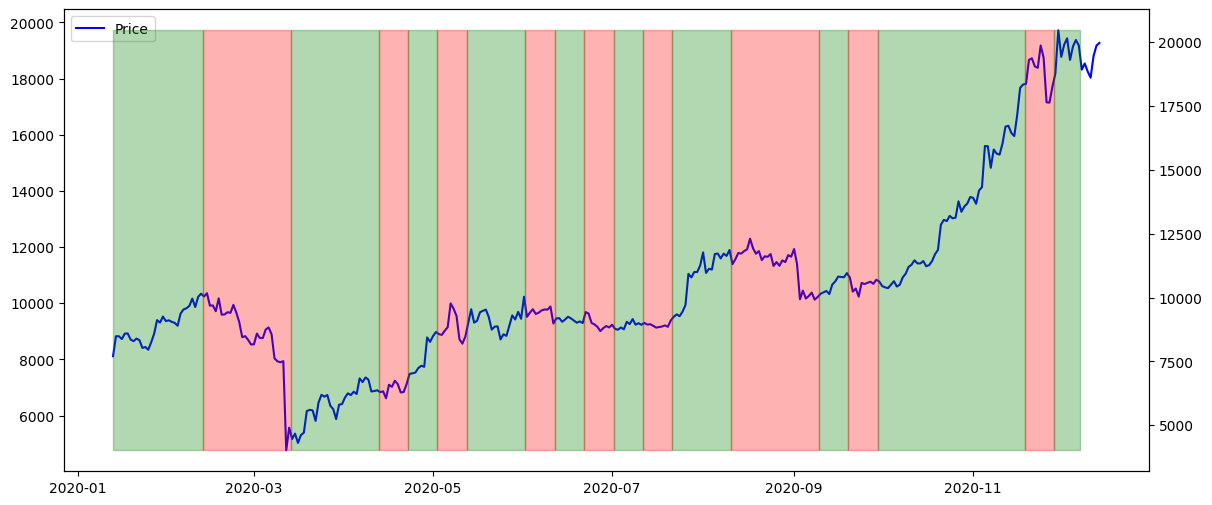

labels
-1    184
 1    152
 0      1
Name: count, dtype: int64

In [97]:
# Apply the best parameters for final labeling
price_df["daily_returns"], price_df["volatility"] = get_daily_vol(price_df.close)
price_df.dropna(inplace=True)
events = get_t_events(price_df.close, price_df.volatility, 1.5)
price_df["event"] = price_df.index.isin(events)
labels = fixed_time_horizon_labeling(price_df.close, 10)
bands = band_generator(labels)
plot_labels(price_df.close, bands)
price_df["labels"] = labels
df_labeled = triple_barrier_labeling(price_df,
                                     upper_barrier_factor=best_params['upper_barrier_factor'],
                                     lower_barrier_factor=best_params['lower_barrier_factor'],
                                     volatility_period=best_params['volatility_period'],
                                     vertical_barrier=best_params['vertical_barrier'],
                                     barrier_type=best_params['barrier_type'],
                                     touch_type=best_params['touch_type'])
# df_labeled.set_index('timestamp', inplace=True)
df_labeled['labels'].value_counts()

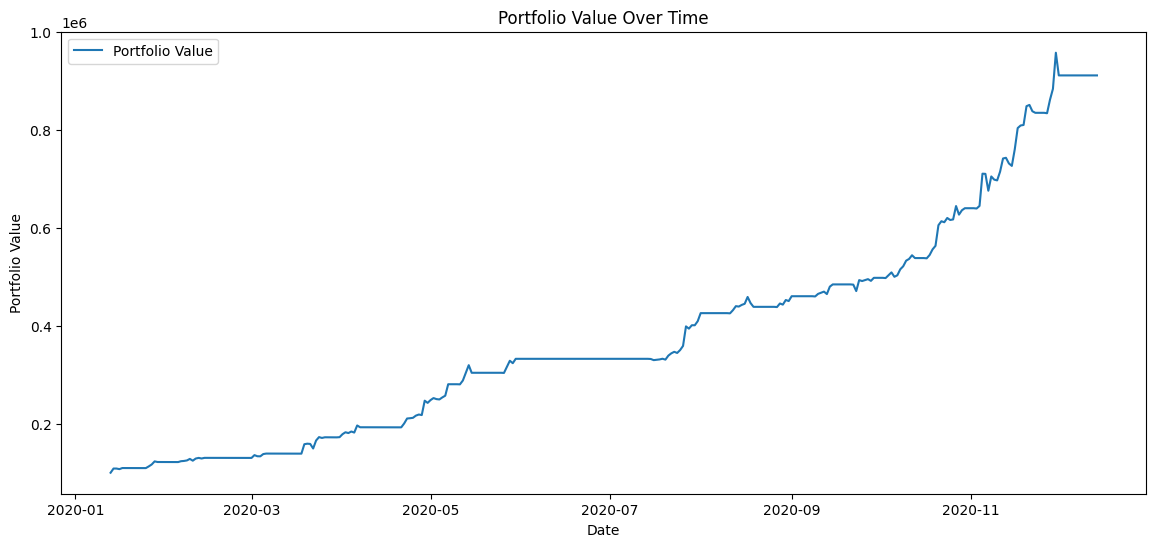

In [98]:
# buy and hold with best parameters
portfolio_values = buy_and_hold(price_df['close'], df_labeled['labels'])
plt.figure(figsize=(14, 6))
plt.plot(portfolio_values.index, portfolio_values.values, label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

### Optimizing Using Scipy

In [45]:
from scipy.optimize import minimize

In [107]:
# Define the ranges manually to make sure for valid values
vol_periods = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

barrier_factors = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

# Define the expanded hyperparameter grid
param_grid = {
    'volatility_period': vol_periods,
    'upper_barrier_factor': barrier_factors,
    'lower_barrier_factor': barrier_factors,
    'vertical_barrier': vol_periods,
    'barrier_type': ['volatility', 'returns'],
    'touch_type': ['HL', 'C']
}

In [85]:
def sharpe_ratio_objective(params, price_df, initial_capital):
    volatility_period, upper_barrier_factor, lower_barrier_factor, vertical_barrier, barrier_type, touch_type = params

    labeled_df = triple_barrier_labeling(price_df,
                                         volatility_period=params[0],
                                         upper_barrier_factor=params[1],
                                         lower_barrier_factor=params[2],
                                         vertical_barrier=params[3],
                                         barrier_type=params[4],
                                         touch_type=params[5])
    labeled_df.set_index(price_df.index, inplace=True)

    portfolio_values = buy_and_hold(price_df['close'], labeled_df['labels'], initial_capital)
    return -calculate_sharpe_ratio(portfolio_values)  # We minimize the negative Sharpe Ratio to maximize the Sharpe Ratio

In [98]:
def tune_hyperparameters_scipy(price_df, param_grid, initial_capital=100000, num_starts=10):
    best_sharpe_ratio = -np.inf
    best_net_profit = -np.inf
    best_params = None

    param_space = [
        vol_periods,
        barrier_factors,
        barrier_factors,
        vol_periods,
        param_grid['barrier_type'],
        param_grid['touch_type']
    ]

    bounds = [
        (0, len(vol_periods) - 1),
        (0, len(barrier_factors) - 1),
        (0, len(barrier_factors) - 1),
        (0, len(vol_periods) - 1),
        (0, len(param_grid['barrier_type']) - 1),
        (0, len(param_grid['touch_type']) - 1)
    ]

    def bounds_to_params(x):
        return [
            vol_periods[int(x[0])],
            barrier_factors[int(x[1])],
            barrier_factors[int(x[2])],
            vol_periods[int(x[3])],
            param_grid['barrier_type'][int(x[4])],
            param_grid['touch_type'][int(x[5])]
        ]

    def objective_wrapper(x, price_df, initial_capital):
        params = bounds_to_params(x)
        return sharpe_ratio_objective(params, price_df, initial_capital)

    for _ in tqdm(range(num_starts), desc="Optimizing"):
        initial_params = [
            np.random.choice(param_space[0]),
            np.random.choice(param_space[1]),
            np.random.choice(param_space[2]),
            np.random.choice(param_space[3]),
            np.random.choice(param_space[4]),
            np.random.choice(param_space[5])
        ]

        initial_guess = [
            vol_periods.index(initial_params[0]),
            barrier_factors.index(initial_params[1]),
            barrier_factors.index(initial_params[2]),
            vol_periods.index(initial_params[3]),
            param_grid['barrier_type'].index(initial_params[4]),
            param_grid['touch_type'].index(initial_params[5])
        ]

        result = minimize(objective_wrapper, initial_guess, args=(price_df, initial_capital), method='SLSQP', bounds=bounds)

        if result.success:
            optimal_params = bounds_to_params(result.x)
            current_sharpe_ratio = -result.fun

            if current_sharpe_ratio > best_sharpe_ratio:
                best_sharpe_ratio = current_sharpe_ratio
                labeled_df = triple_barrier_labeling(price_df,
                                                     volatility_period=optimal_params[0],
                                                     upper_barrier_factor=optimal_params[1],
                                                     lower_barrier_factor=optimal_params[2],
                                                     vertical_barrier=optimal_params[3],
                                                     barrier_type=optimal_params[4],
                                                     touch_type=optimal_params[5])
                labeled_df.set_index(price_df.index, inplace=True)
                portfolio_values = buy_and_hold(price_df['close'], labeled_df['labels'], initial_capital)
                best_net_profit = portfolio_values.iloc[-1] - initial_capital
                best_params = optimal_params

    return best_params, best_sharpe_ratio, best_net_profit

In [108]:
# Example usage
best_params, best_sharpe_ratio, best_net_profit = tune_hyperparameters_scipy(price_df, param_grid)
print(f"Best Params: {best_params}, Best Sharpe Ratio: {best_sharpe_ratio}, Best Net Profit: {best_net_profit}")

Optimizing: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

Best Params: [8, 1.0, 1.1, 5, 'volatility', 'HL'], Best Sharpe Ratio: 5.478801384938411, Best Net Profit: 1278173.69218


## Test the Best Params Found

In [109]:
best_params

[8, 1.0, 1.1, 5, 'volatility', 'HL']

In [110]:
tbl_df = triple_barrier_labeling(price_df, volatility_period=best_params[0], upper_barrier_factor=best_params[1], lower_barrier_factor=best_params[2], vertical_barrier=best_params[3], min_trend_days=2, barrier_type=best_params[4], touch_type=best_params[5])

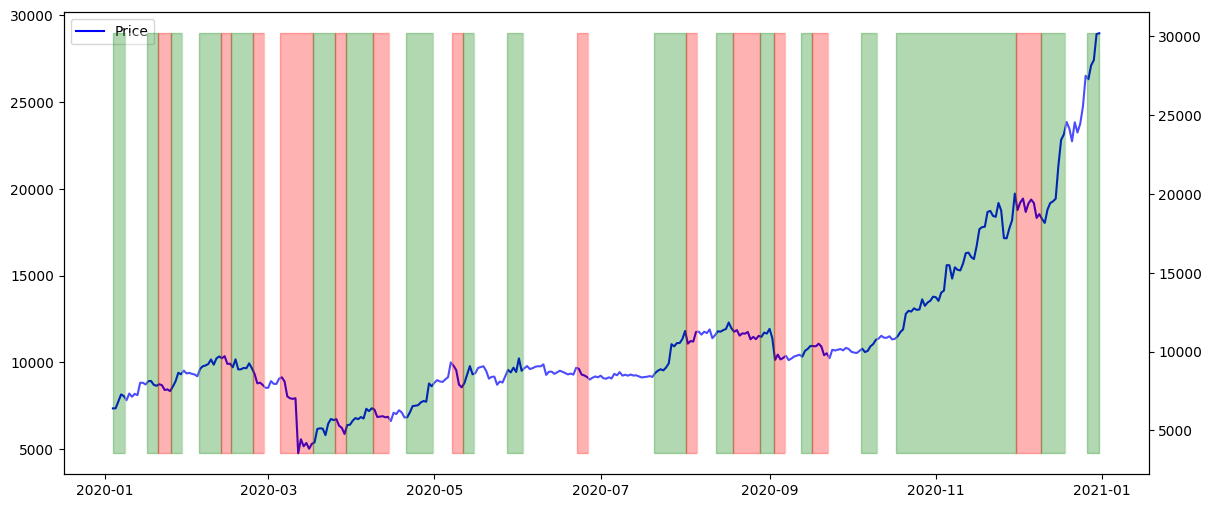

In [111]:
prices = tbl_df
bands = band_generator(prices.labels)
plot_labels(prices.close, bands)

In [112]:
prices.labels.value_counts()

labels
 1    158
 0    129
-1     76
Name: count, dtype: int64

In [113]:
np.bincount(prices.labels + 1)

array([ 76, 129, 158])

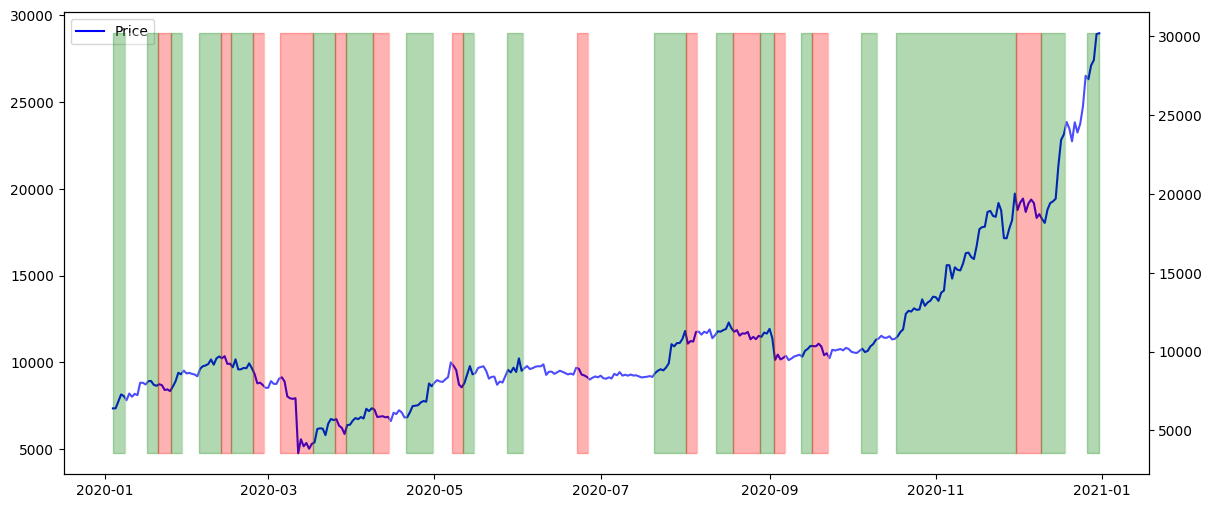

labels
 1    158
 0    129
-1     76
Name: count, dtype: int64

In [115]:
# Testing for assurance
tbl_df = triple_barrier_labeling(price_df, volatility_period=best_params[0], upper_barrier_factor=best_params[1], lower_barrier_factor=best_params[2], vertical_barrier=best_params[3], min_trend_days=2, barrier_type=best_params[4], touch_type=best_params[5])
prices = tbl_df
bands = band_generator(prices.labels)
plot_labels(prices.close, bands)
prices.labels.value_counts()

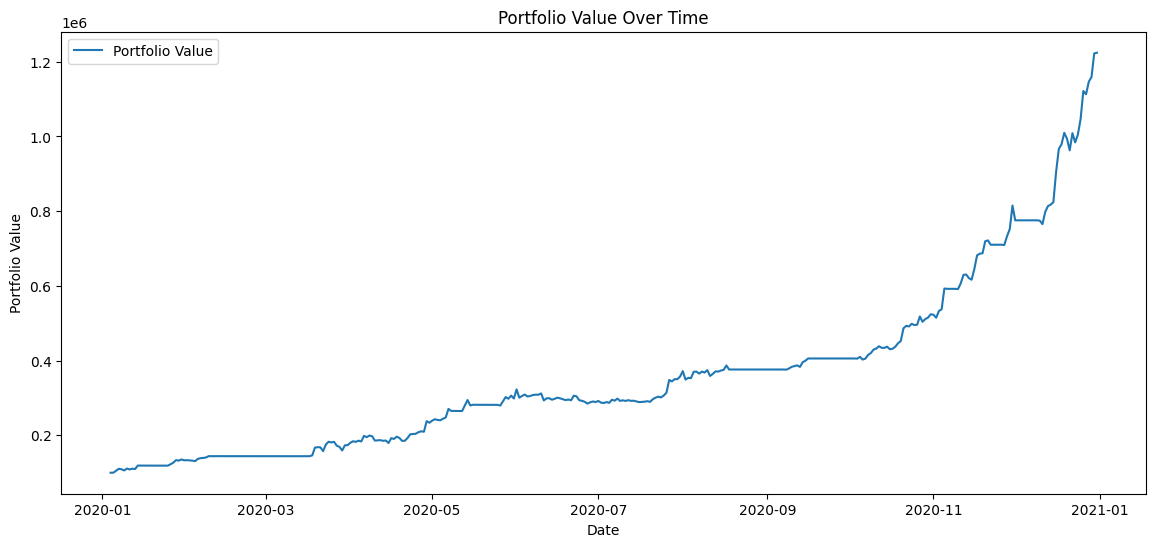

In [95]:
# buy and hold with best parameters
portfolio_values = buy_and_hold(prices.close, prices.labels)
plt.figure(figsize=(14, 6))
plt.plot(portfolio_values.index, portfolio_values.values, label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

### Hand-fine-tuned Params Test

In [96]:
tbl_df = triple_barrier_labeling(price_df, volatility_period=10, upper_barrier_factor=1.5, lower_barrier_factor=1.2, vertical_barrier=7, min_trend_days=2, barrier_type='volatility')

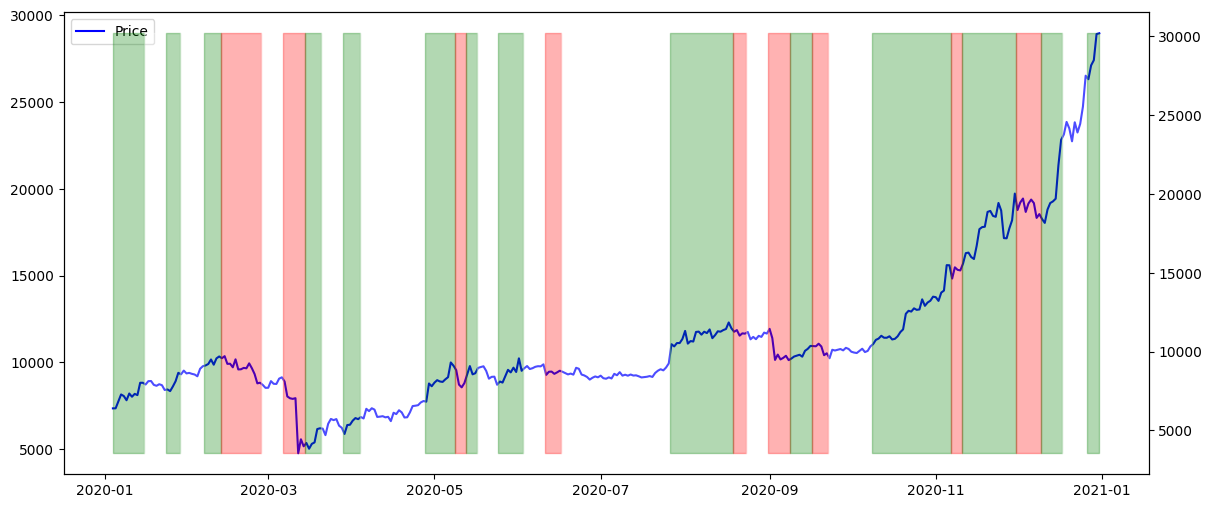

In [97]:
prices = tbl_df
bands = band_generator(prices.labels)
plot_labels(prices.close, bands)

In [98]:
prices.labels.value_counts()

labels
 1    152
 0    146
-1     65
Name: count, dtype: int64

In [99]:
portfolio_vals = buy_and_hold(prices.close, prices.labels, 100000)
calculate_sharpe_ratio(portfolio_vals)

4.818891293766802